<a href="https://colab.research.google.com/github/gayathrirx/genAIAudio/blob/main/GenAIforAudio_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fake Audio Detector


A fake audio detector analyzes audio data to identify and classify audio content as legitimate or fake.
What is fake audio?
Fake audio is misinformation, disinformation, and mal-information presented in audio formats that can mislead listeners.
The model uses its training to assess the authenticity and reliability of the audio content.  

Objective: A fake Audio Detector using a Large Language Model(LLM) designed to analyze audio data to identify and classify content as legitimate or fake. "Fake audio" refers to misinformation,disinformation and mal-information presented in audio formats that can mislead listeners. The input dataset might include podcasts, speeches, and other forms of spoken content. The model uses its training to assess the authenticity and reliability of the audio content.




In [ ]:
import pandas as pd
from google.colab import drive # Used for mounting Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the path to the dataset
dataset_path = '/content/drive/MyDrive/ESC-50-master'

# Load the metadata
metadata = pd.read_csv(os.path.join(dataset_path, 'meta/esc50.csv'))

# Display the first few rows of the metadata
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
# Display basic information about the audio files
audio_durations = []
for file in metadata['filename']:
    file_path = os.path.join(dataset_path, 'audio', file)
    audio, sr = librosa.load(file_path, sr=None)
    audio_durations.append(librosa.get_duration(y=audio, sr=sr))

# Convert to a DataFrame for analysis
audio_df = pd.DataFrame({'file': metadata['filename'], 'duration': audio_durations})
audio_df.head()

,file,duration
0,1-100032-A-0.wav,5.0
1,1-100038-A-14.wav,5.0
2,1-100210-A-36.wav,5.0
3,1-100210-B-36.wav,5.0
4,1-101296-A-19.wav,5.0


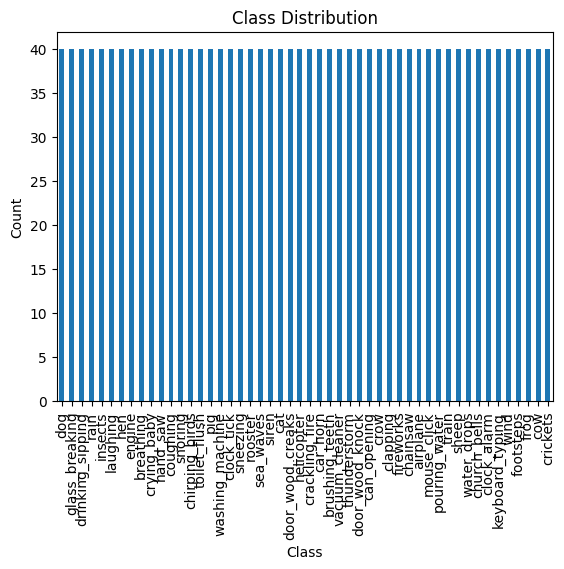

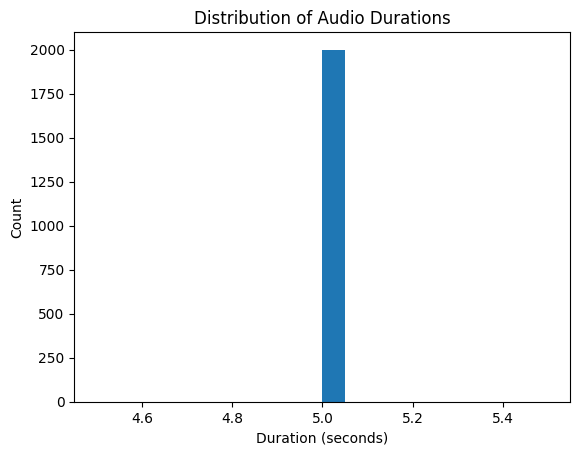

In [ ]:
# Plot the distribution of classes
metadata['category'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Convert to a DataFrame for analysis
audio_df = pd.DataFrame({'file': metadata['filename'], 'duration': audio_durations})
audio_df.head()

# Plot the distribution of audio durations
audio_df['duration'].plot(kind='hist', bins=20, title='Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

In [ ]:
#Select a Pre-trained LLM for Audio: We will use the Wav2Vec 2.0 model for this task.
!pip install accelerate>=0.21.0
!pip install transformers[torch]
!pip install transformers
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import torch

# Load the pre-trained model and processor
model_name = "facebook/wav2vec2-base-960h"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=50)
processor = Wav2Vec2Processor.from_pretrained(model_name)

In [ ]:
#Evaluate the Pre-trained Model:

def preprocess_audio(file_path):
    audio, _ = librosa.load(file_path, sr=16000)
    return audio

def predict(audio):
    inputs = processor(audio, return_tensors="pt", padding=True, sampling_rate=16000)
    with torch.no_grad():
        logits = model(inputs.input_values).logits
    predicted_class_ids = torch.argmax(logits, dim=-1).item()
    return predicted_class_ids

# Example evaluation
test_audio_path = os.path.join(dataset_path, 'audio', metadata['filename'][0])
audio = preprocess_audio(test_audio_path)
prediction = predict(audio)
print(f"Predicted Label: {prediction}")

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import BatchFeature

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)